# Optimization WFA - Support Vector Regression

## Support Vector Regression with scikit-learn 

In [20]:
import sys
sys.path.append('../../')

In [21]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades

In [22]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from util.Save_result_return import save_to_csv

plt.style.use("seaborn-v0_8")

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
plt.style.use("seaborn-v0_8")

In [24]:
from backtesting import Strategy

In [25]:
import warnings
warnings.simplefilter("ignore")

## Getting the Data

In [26]:
XAUUSD = load_data()

In [27]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [28]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


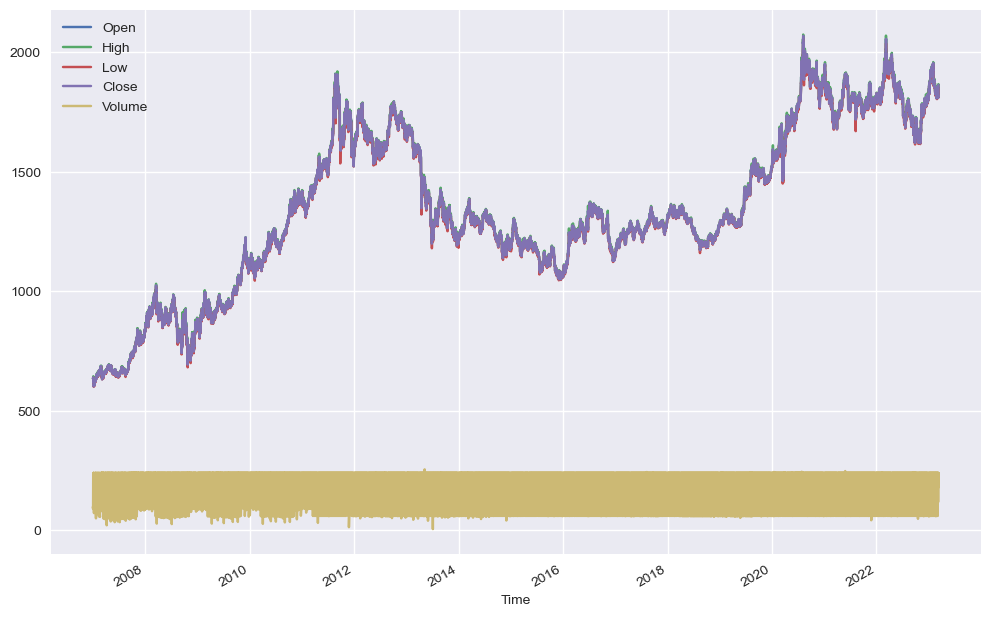

In [29]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [30]:
class Support_Vector_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [31]:
mainFolder = 'Machine_Learning'
strategy = Support_Vector_Regression
strategyName = 'Support_Vector_Regression'
account_size = 1000
folder_ML_Strategy = 'Support Vector Regression'
subFolder = 'Optimization'

In [32]:
class ML_Regression():

    def __init__(self, data, strategy, start_train,  end_train,  TF, window_size, account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.end_train = end_train
        self.TF = TF
        self.window_size = window_size
        self.account_size = account_size
        self.data_train = None
        self.results = None
        self.model = None

    def Prepare(self , future_days = 1):
        df = self.data.loc[self.start_train:self.end_train].copy()

        target_col = f"{future_days}_Day_Price_Forecast"
        df[target_col] = df['Close'].shift(-future_days)

        # Drop rows with NaN in the newly created column
        df.dropna(subset=[target_col], inplace=True)

      

        df['pred'] = 0

        model = SVR(kernel='rbf', C=1e3, gamma=0.00001)

        for i in range(self.window_size, len(df)):
            rolling_window_data = df.iloc[i - self.window_size:i]

            # Features (Close price as input)
            features = rolling_window_data[['Close']].copy()
            target = rolling_window_data[target_col].copy()

            model.fit(features, target)

            # Predict for the next data point
            pred_value = model.predict(
                np.array(df['Close'].iloc[i]).reshape(1, -1))
            df.at[df.index[i], 'pred'] = np.where(
                (pred_value > df['Close'][i]), 1, -1)

        self.data_train = df
      

    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        account_size = self.account_size
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1/100)
        result = backtest.run()
        return result

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        return result_train

## TF D1

In [33]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'D1'

### Window size 1 year

In [34]:
data = XAUUSD['D1']
window_size = 252
WFA = '1y'

In [35]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [36]:
test = ml.Run()

In [37]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-09 00:00:00
Duration                   5911 days 00:00:00
Exposure Time [%]                    94.98215
Equity Final [$]                      853.113
Equity Peak [$]                      1412.133
Return [%]                           -14.6887
Buy & Hold Return [%]              187.984143
Return (Ann.) [%]                   -0.790857
Volatility (Ann.) [%]               20.188224
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -52.056499
Avg. Drawdown [%]                   -9.441541
Max. Drawdown Duration     2844 days 00:00:00
Avg. Drawdown Duration      234 days 00:00:00
# Trades                                  420
Win Rate [%]                        60.238095
Best Trade [%]                      13.013994
Worst Trade [%]                    -25.115644
Avg. Trade [%]                    

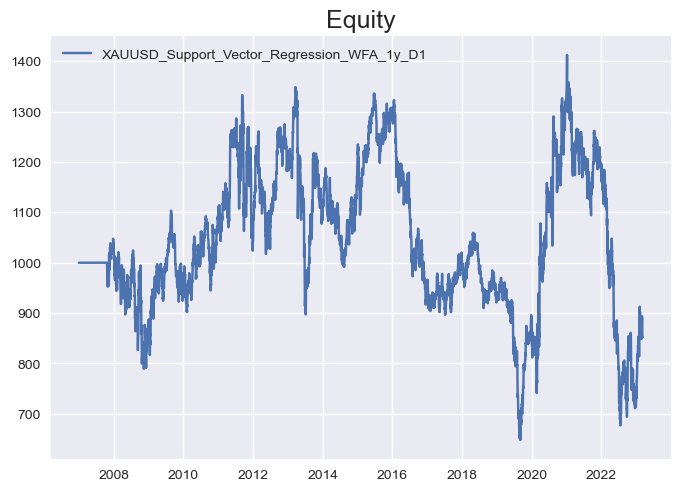

In [38]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [39]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [40]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [41]:
data = XAUUSD['D1']
window_size = 252 * 2
WFA = '2y'

In [42]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [43]:
test = ml.Run()

In [44]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-09 00:00:00
Duration                   5911 days 00:00:00
Exposure Time [%]                   89.984133
Equity Final [$]                     1474.111
Equity Peak [$]                      1656.224
Return [%]                            47.4111
Buy & Hold Return [%]              187.984143
Return (Ann.) [%]                    1.958436
Volatility (Ann.) [%]               18.718985
Sharpe Ratio                         0.104623
Sortino Ratio                         0.15471
Calmar Ratio                         0.035848
Max. Drawdown [%]                  -54.632224
Avg. Drawdown [%]                   -3.835767
Max. Drawdown Duration     4375 days 00:00:00
Avg. Drawdown Duration      108 days 00:00:00
# Trades                                  281
Win Rate [%]                         67.97153
Best Trade [%]                      17.911389
Worst Trade [%]                     -30.02789
Avg. Trade [%]                    

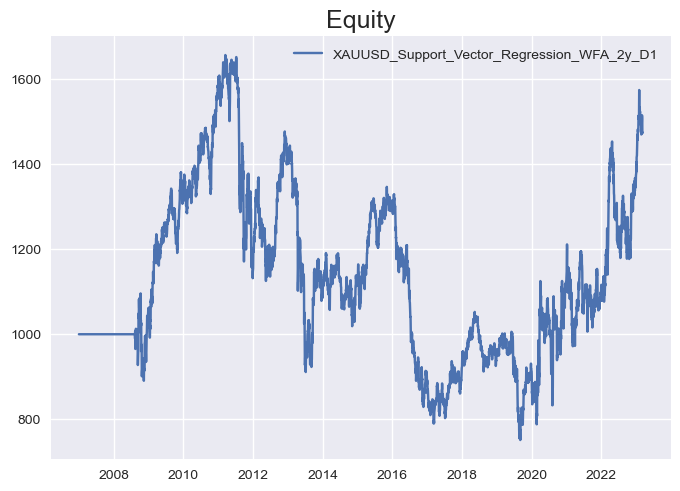

In [45]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [46]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [47]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [48]:
data = XAUUSD['D1']
window_size = 252 * 3
WFA = '3y'

In [49]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [50]:
test = ml.Run()

In [51]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-09 00:00:00
Duration                   5911 days 00:00:00
Exposure Time [%]                   84.986117
Equity Final [$]                     1466.524
Equity Peak [$]                      1566.374
Return [%]                            46.6524
Buy & Hold Return [%]              187.984143
Return (Ann.) [%]                    1.932144
Volatility (Ann.) [%]                21.64763
Sharpe Ratio                         0.089254
Sortino Ratio                        0.130779
Calmar Ratio                         0.038376
Max. Drawdown [%]                  -50.348067
Avg. Drawdown [%]                   -4.250452
Max. Drawdown Duration     4003 days 00:00:00
Avg. Drawdown Duration      156 days 00:00:00
# Trades                                  230
Win Rate [%]                        72.173913
Best Trade [%]                       7.105961
Worst Trade [%]                    -25.415595
Avg. Trade [%]                    

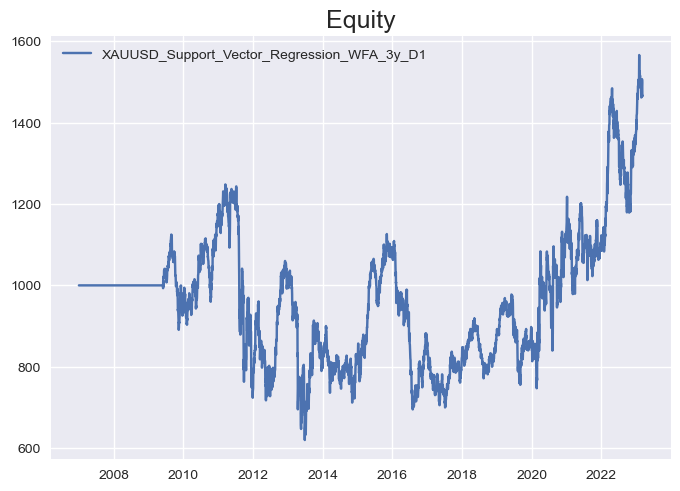

In [52]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [53]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [54]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [55]:
data = XAUUSD['D1']
window_size = 252 * 4
WFA = '4y'

In [56]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [57]:
test = ml.Run()

In [58]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-09 00:00:00
Duration                   5911 days 00:00:00
Exposure Time [%]                     79.9881
Equity Final [$]                      1185.09
Equity Peak [$]                      1341.945
Return [%]                             18.509
Buy & Hold Return [%]              187.984143
Return (Ann.) [%]                    0.852369
Volatility (Ann.) [%]               25.916744
Sharpe Ratio                         0.032889
Sortino Ratio                        0.048675
Calmar Ratio                         0.011947
Max. Drawdown [%]                  -71.345621
Avg. Drawdown [%]                   -4.537781
Max. Drawdown Duration     4375 days 00:00:00
Avg. Drawdown Duration      169 days 00:00:00
# Trades                                  235
Win Rate [%]                        65.531915
Best Trade [%]                       9.302592
Worst Trade [%]                    -26.699089
Avg. Trade [%]                    

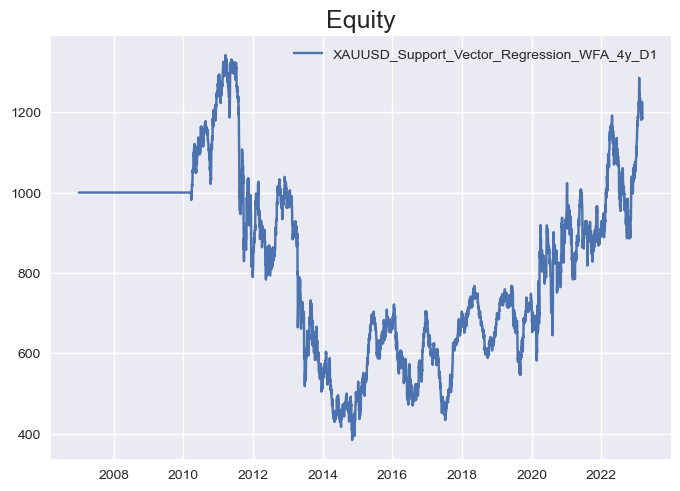

In [59]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [60]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [61]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [62]:
data = XAUUSD['D1']
window_size = 252 * 5
WFA = '5y'

In [63]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [64]:
test = ml.Run()

In [65]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-09 00:00:00
Duration                   5911 days 00:00:00
Exposure Time [%]                   74.990083
Equity Final [$]                     1359.058
Equity Peak [$]                      1458.908
Return [%]                            35.9058
Buy & Hold Return [%]              187.984143
Return (Ann.) [%]                    1.545167
Volatility (Ann.) [%]               34.954311
Sharpe Ratio                         0.044205
Sortino Ratio                        0.066218
Calmar Ratio                         0.019071
Max. Drawdown [%]                  -81.022524
Avg. Drawdown [%]                   -9.273311
Max. Drawdown Duration     3580 days 00:00:00
Avg. Drawdown Duration      260 days 00:00:00
# Trades                                  181
Win Rate [%]                         69.61326
Best Trade [%]                      10.490008
Worst Trade [%]                    -25.095968
Avg. Trade [%]                    

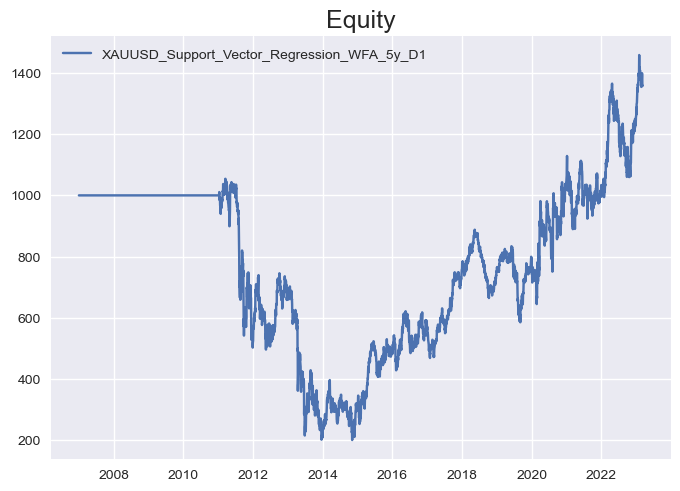

In [66]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [67]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [68]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [69]:
data = XAUUSD['D1']
window_size = 252 * 6
WFA = '6y'

In [70]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [71]:
test = ml.Run()

In [72]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-09 00:00:00
Duration                   5911 days 00:00:00
Exposure Time [%]                   69.992067
Equity Final [$]                     1723.549
Equity Peak [$]                      1823.399
Return [%]                            72.3549
Buy & Hold Return [%]              187.984143
Return (Ann.) [%]                    2.758201
Volatility (Ann.) [%]               18.567924
Sharpe Ratio                         0.148547
Sortino Ratio                        0.218191
Calmar Ratio                         0.051832
Max. Drawdown [%]                  -53.214554
Avg. Drawdown [%]                   -6.550226
Max. Drawdown Duration     1772 days 00:00:00
Avg. Drawdown Duration      121 days 00:00:00
# Trades                                  151
Win Rate [%]                        78.145695
Best Trade [%]                       8.600775
Worst Trade [%]                    -26.183055
Avg. Trade [%]                    

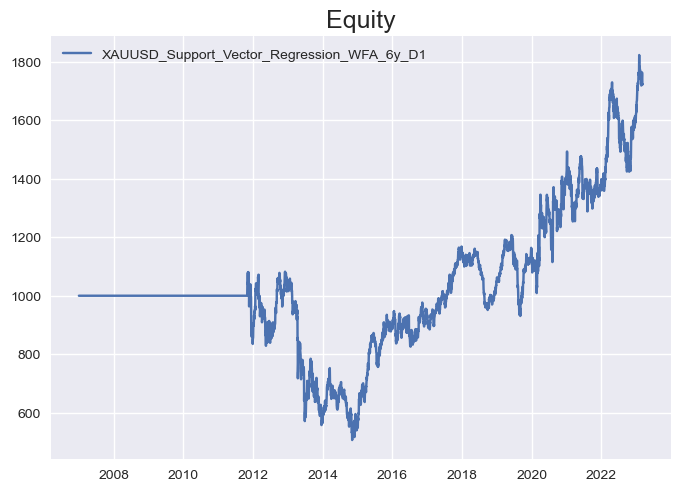

In [73]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [74]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [75]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [76]:
data = XAUUSD['D1']
window_size = 252 * 7
WFA = '7y'

In [77]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [78]:
test = ml.Run()

In [79]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-09 00:00:00
Duration                   5911 days 00:00:00
Exposure Time [%]                    64.99405
Equity Final [$]                     1369.911
Equity Peak [$]                      1469.761
Return [%]                            36.9911
Buy & Hold Return [%]              187.984143
Return (Ann.) [%]                    1.585543
Volatility (Ann.) [%]               20.282686
Sharpe Ratio                         0.078172
Sortino Ratio                        0.115358
Calmar Ratio                         0.025797
Max. Drawdown [%]                  -61.461818
Avg. Drawdown [%]                   -5.523099
Max. Drawdown Duration     3379 days 00:00:00
Avg. Drawdown Duration      183 days 00:00:00
# Trades                                  133
Win Rate [%]                         75.18797
Best Trade [%]                       9.448429
Worst Trade [%]                    -26.378429
Avg. Trade [%]                    

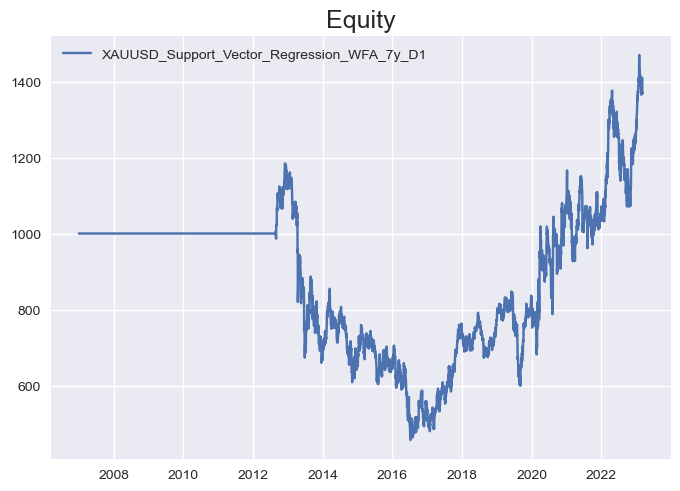

In [80]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [81]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [82]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [83]:
data = XAUUSD['D1']
window_size = 252 * 8
WFA = '8y'

In [84]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [85]:
test = ml.Run()

In [86]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-09 00:00:00
Duration                   5911 days 00:00:00
Exposure Time [%]                   59.996033
Equity Final [$]                     1898.698
Equity Peak [$]                      1998.548
Return [%]                            89.8698
Buy & Hold Return [%]              187.984143
Return (Ann.) [%]                     3.25647
Volatility (Ann.) [%]               13.482903
Sharpe Ratio                         0.241526
Sortino Ratio                        0.369666
Calmar Ratio                         0.103114
Max. Drawdown [%]                  -31.581257
Avg. Drawdown [%]                   -4.334611
Max. Drawdown Duration      986 days 00:00:00
Avg. Drawdown Duration       69 days 00:00:00
# Trades                                  121
Win Rate [%]                        74.380165
Best Trade [%]                       9.448429
Worst Trade [%]                      -12.9937
Avg. Trade [%]                    

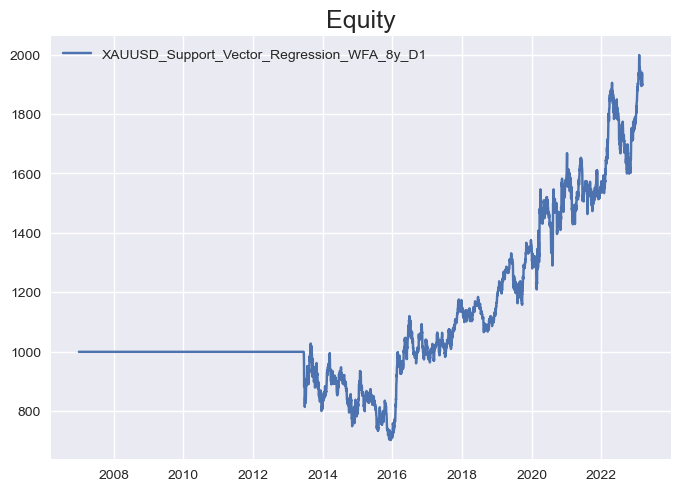

In [87]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [88]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [89]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H4

In [90]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'H4'

### Window size 1 year

In [91]:
data = XAUUSD['H4']
window_size = 252 * 6
WFA = '1y'

In [92]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [93]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 04:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                   94.174944
Equity Final [$]                     2036.992
Equity Peak [$]                      2271.285
Return [%]                           103.6992
Buy & Hold Return [%]              193.059294
Return (Ann.) [%]                     3.61921
Volatility (Ann.) [%]               13.586287
Sharpe Ratio                         0.266387
Sortino Ratio                        0.385887
Calmar Ratio                         0.088991
Max. Drawdown [%]                  -40.669387
Avg. Drawdown [%]                   -1.544429
Max. Drawdown Duration     3261 days 00:00:00
Avg. Drawdown Duration       38 days 12:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                     129.966299
Worst Trade [%]                    129.966299
Avg. Trade [%]                    

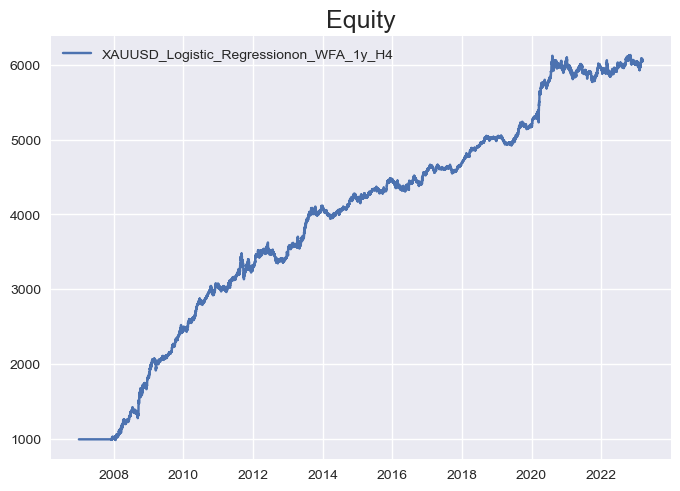

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [ ]:
data = XAUUSD['H4']
window_size = 252 * 2 * 6
WFA = '2y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   88.351496
Equity Final [$]                     4982.284
Equity Peak [$]                      5082.109
Return [%]                           398.2284
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    8.357154
Volatility (Ann.) [%]                8.347789
Sharpe Ratio                         1.001122
Sortino Ratio                        1.623095
Calmar Ratio                         0.480448
Max. Drawdown [%]                  -17.394505
Avg. Drawdown [%]                   -0.646426
Max. Drawdown Duration      727 days 20:00:00
Avg. Drawdown Duration        9 days 15:00:00
# Trades                                 7895
Win Rate [%]                        55.148828
Best Trade [%]                       5.490625
Worst Trade [%]                     -6.215651
Avg. Trade [%]                    

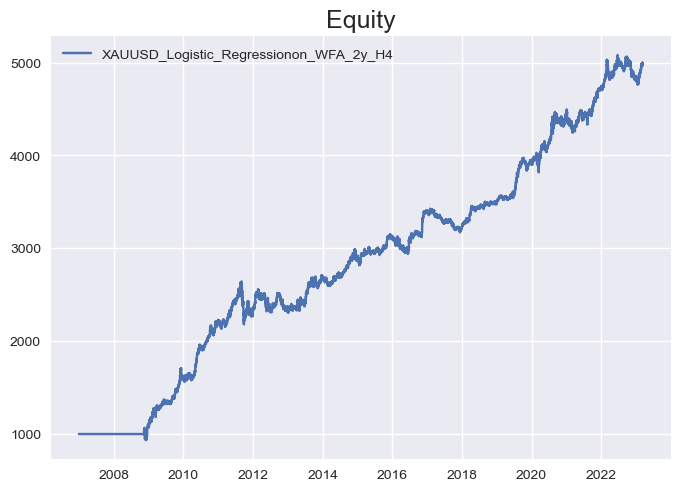

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [ ]:
data = XAUUSD['H4']
window_size = 252 * 3 * 6
WFA = '3y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   82.529169
Equity Final [$]                     3344.799
Equity Peak [$]                      3788.224
Return [%]                           234.4799
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    6.220441
Volatility (Ann.) [%]                9.188765
Sharpe Ratio                         0.676962
Sortino Ratio                        1.051407
Calmar Ratio                         0.301683
Max. Drawdown [%]                    -20.6191
Avg. Drawdown [%]                    -0.94416
Max. Drawdown Duration     1099 days 04:00:00
Avg. Drawdown Duration       15 days 10:00:00
# Trades                                 7148
Win Rate [%]                        54.420817
Best Trade [%]                       5.490625
Worst Trade [%]                     -6.215651
Avg. Trade [%]                    

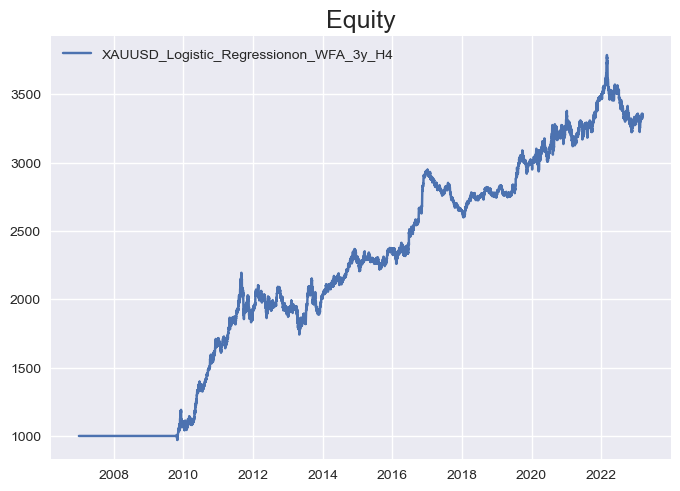

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [ ]:
data = XAUUSD['H4']
window_size = 252 * 4 * 6
WFA = '4y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   76.706843
Equity Final [$]                     2045.753
Equity Peak [$]                      2345.186
Return [%]                           104.5753
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    3.642169
Volatility (Ann.) [%]               13.333005
Sharpe Ratio                         0.273169
Sortino Ratio                        0.401116
Calmar Ratio                         0.089139
Max. Drawdown [%]                   -40.85958
Avg. Drawdown [%]                   -1.923396
Max. Drawdown Duration     3064 days 12:00:00
Avg. Drawdown Duration       35 days 21:00:00
# Trades                                 6281
Win Rate [%]                        54.402165
Best Trade [%]                       5.490625
Worst Trade [%]                     -6.243967
Avg. Trade [%]                    

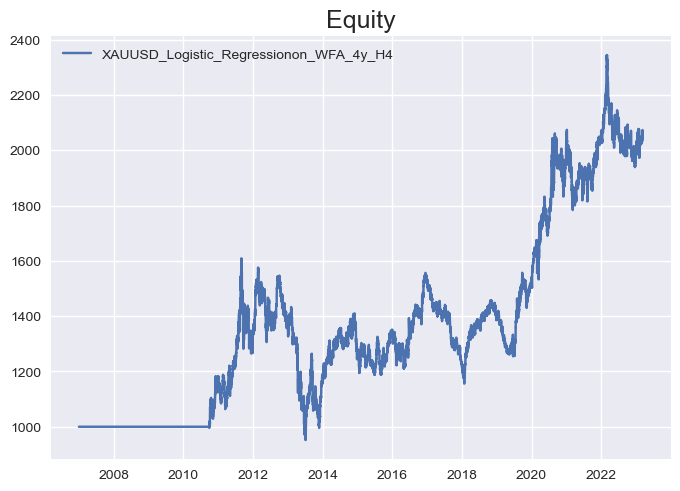

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['H4']
window_size = 252 * 5 * 6
WFA = '5y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, 500)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   11.032385
Equity Final [$]                         4.15
Equity Peak [$]                       578.217
Return [%]                             -99.17
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                  -21.296295
Volatility (Ann.) [%]               33.648071
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.283487
Avg. Drawdown [%]                  -20.339638
Max. Drawdown Duration     3824 days 08:00:00
Avg. Drawdown Duration      382 days 02:00:00
# Trades                                  596
Win Rate [%]                        51.845638
Best Trade [%]                       3.688428
Worst Trade [%]                     -6.243967
Avg. Trade [%]                    

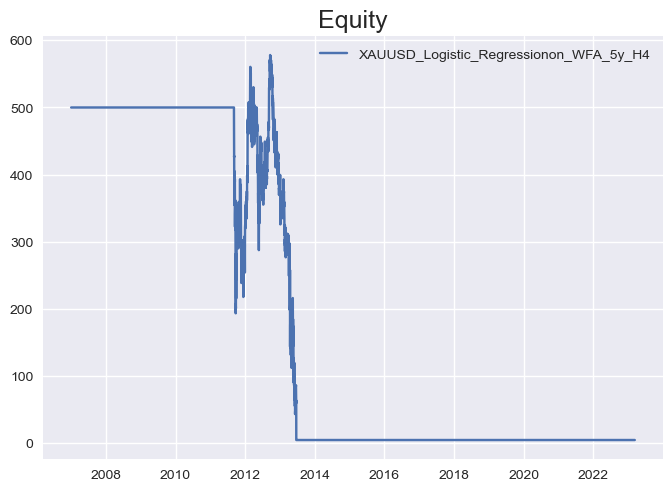

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['H4']
window_size = 252 * 6 * 6
WFA = '6y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                    65.06219
Equity Final [$]                      992.467
Equity Peak [$]                      1305.822
Return [%]                            -0.7533
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                   -0.037785
Volatility (Ann.) [%]                22.05322
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -67.935095
Avg. Drawdown [%]                   -5.585939
Max. Drawdown Duration     3442 days 08:00:00
Avg. Drawdown Duration      175 days 03:00:00
# Trades                                 5493
Win Rate [%]                         54.23266
Best Trade [%]                        5.73108
Worst Trade [%]                     -6.243967
Avg. Trade [%]                    

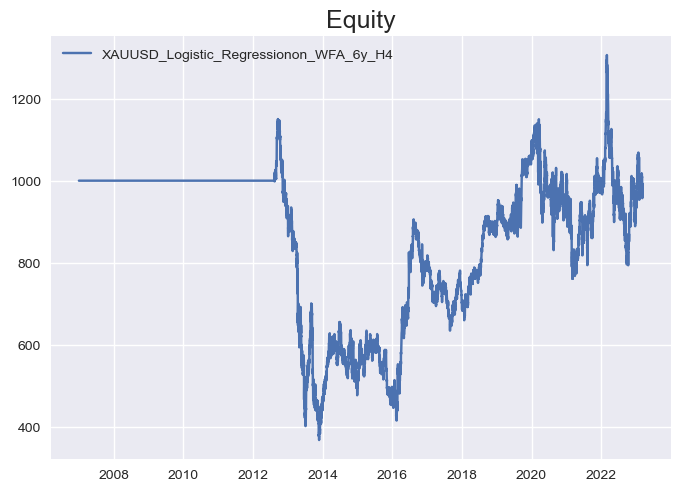

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['H4']
window_size = 252 * 7 * 6
WFA = '7y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   59.239863
Equity Final [$]                     1078.219
Equity Peak [$]                      1709.518
Return [%]                             7.8219
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    0.377113
Volatility (Ann.) [%]               13.068423
Sharpe Ratio                         0.028857
Sortino Ratio                        0.040288
Calmar Ratio                         0.008393
Max. Drawdown [%]                   -44.93442
Avg. Drawdown [%]                   -1.897392
Max. Drawdown Duration     1255 days 20:00:00
Avg. Drawdown Duration       36 days 00:00:00
# Trades                                 5465
Win Rate [%]                        54.565416
Best Trade [%]                        5.73108
Worst Trade [%]                     -5.205037
Avg. Trade [%]                    

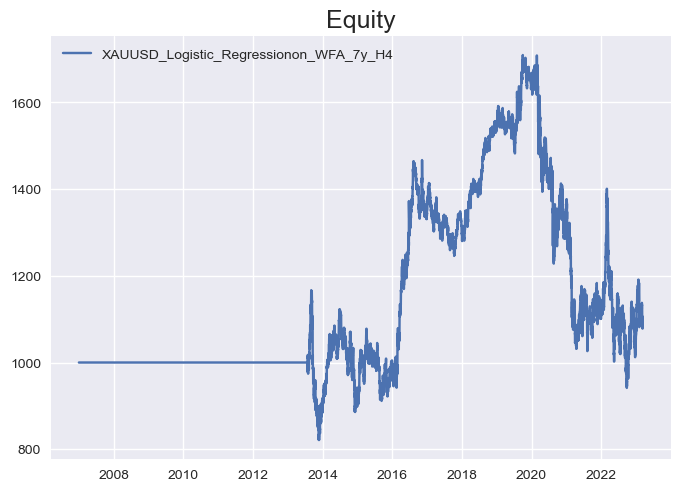

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['H4']
window_size = 252 * 8 * 6
WFA = '8y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   53.417536
Equity Final [$]                     1383.415
Equity Peak [$]                      1840.686
Return [%]                            38.3415
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                     1.63536
Volatility (Ann.) [%]               11.979533
Sharpe Ratio                         0.136513
Sortino Ratio                        0.199741
Calmar Ratio                         0.046617
Max. Drawdown [%]                  -35.080834
Avg. Drawdown [%]                   -1.288367
Max. Drawdown Duration     1246 days 08:00:00
Avg. Drawdown Duration       20 days 14:00:00
# Trades                                 5240
Win Rate [%]                        53.912214
Best Trade [%]                        5.73108
Worst Trade [%]                     -4.467755
Avg. Trade [%]                    

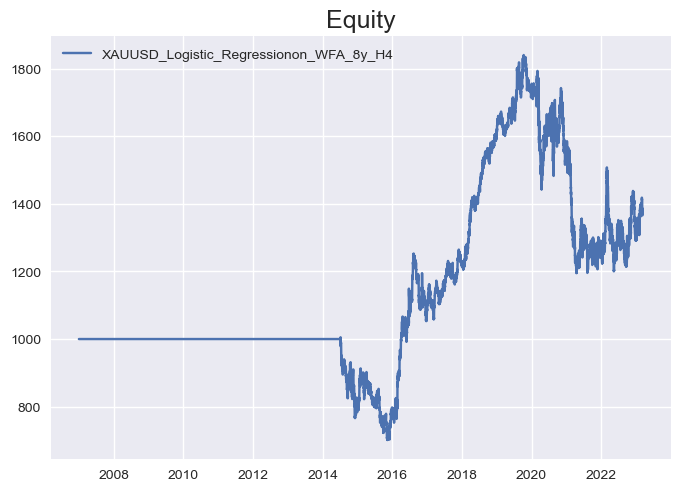

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H1

In [ ]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'H1'

### Window size 1 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 24
WFA = '1y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   93.824211
Equity Final [$]                     4481.844
Equity Peak [$]                      4680.071
Return [%]                           348.1844
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    7.783792
Volatility (Ann.) [%]                9.858876
Sharpe Ratio                         0.789521
Sortino Ratio                        1.266437
Calmar Ratio                         0.390236
Max. Drawdown [%]                  -19.946346
Avg. Drawdown [%]                   -0.541705
Max. Drawdown Duration      503 days 21:00:00
Avg. Drawdown Duration        6 days 18:00:00
# Trades                                28222
Win Rate [%]                        53.316562
Best Trade [%]                       6.254102
Worst Trade [%]                     -7.854516
Avg. Trade [%]                    

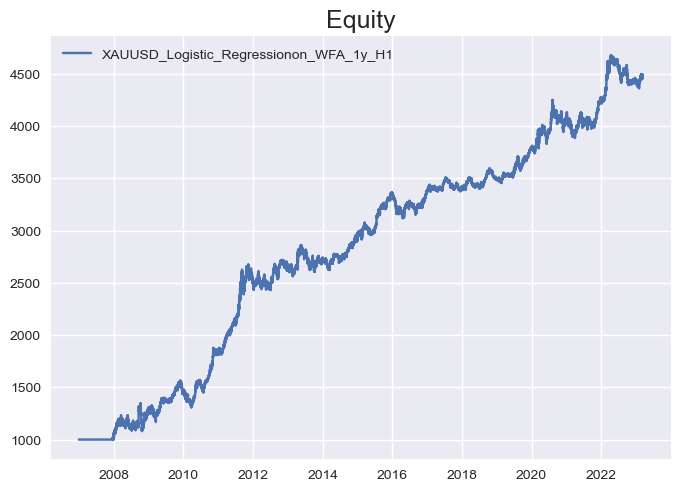

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 2 * 24
WFA = '2y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   87.649443
Equity Final [$]                     3455.661
Equity Peak [$]                      3455.661
Return [%]                           245.5661
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    6.392383
Volatility (Ann.) [%]                 9.56018
Sharpe Ratio                         0.668647
Sortino Ratio                        1.034088
Calmar Ratio                         0.338543
Max. Drawdown [%]                  -18.882055
Avg. Drawdown [%]                   -0.693125
Max. Drawdown Duration     1071 days 08:00:00
Avg. Drawdown Duration        9 days 08:00:00
# Trades                                23023
Win Rate [%]                        53.637667
Best Trade [%]                       4.426038
Worst Trade [%]                     -5.401112
Avg. Trade [%]                    

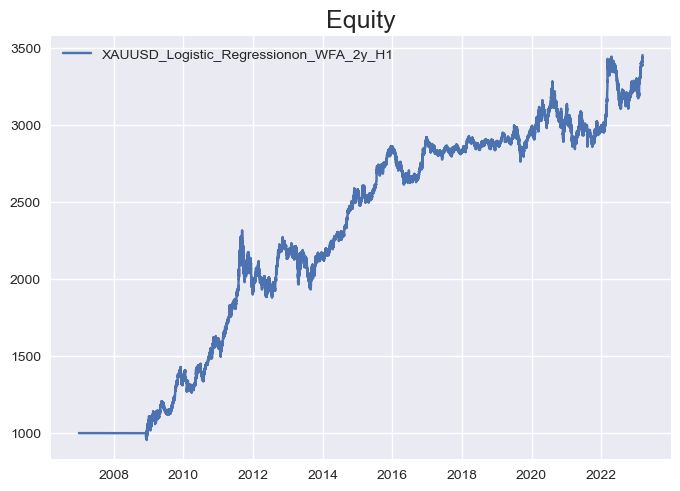

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 3 * 24
WFA = '3y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   81.474675
Equity Final [$]                     2603.657
Equity Peak [$]                       2704.48
Return [%]                           160.3657
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    4.897908
Volatility (Ann.) [%]               11.207171
Sharpe Ratio                         0.437033
Sortino Ratio                        0.652963
Calmar Ratio                         0.191909
Max. Drawdown [%]                  -25.521974
Avg. Drawdown [%]                   -0.895694
Max. Drawdown Duration     1303 days 04:00:00
Avg. Drawdown Duration       13 days 07:00:00
# Trades                                19828
Win Rate [%]                        54.120436
Best Trade [%]                       3.223874
Worst Trade [%]                     -7.328009
Avg. Trade [%]                    

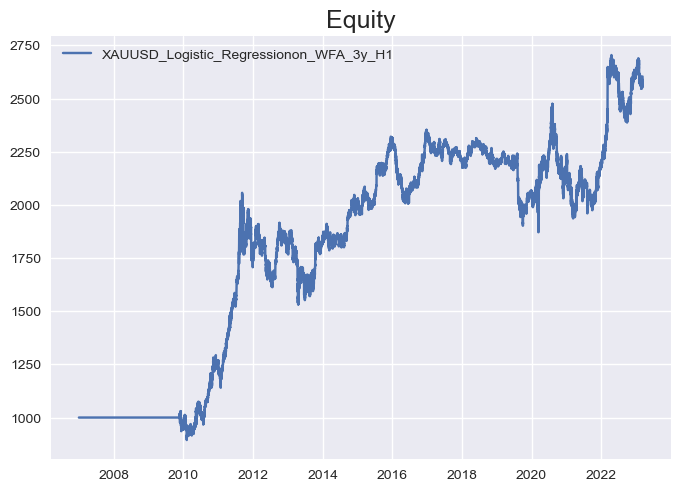

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 4 * 24
WFA = '4y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 5 * 24
WFA = '5y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 6 * 24
WFA = '6y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 7 * 24
WFA = '7y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 8 * 24
WFA = '8y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H30

In [ ]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'M30'

### Window size 1 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 48
WFA = '1y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 2 * 48
WFA = '2y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 3 * 48
WFA = '3y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 4 * 48
WFA = '4y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 5 * 48
WFA = '5y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 6 * 48
WFA = '6y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 7 * 48 
WFA = '7y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 8 * 48
WFA = '8y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')